In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import researchpy as rp
import scipy.stats as stats

from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.model_selection import train_test_split

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier

from mlxtend.plotting import plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier, plot_importance

In [63]:
pd.set_option('display.float_format', '{:.5f}'.format) 

In [64]:
final_data = pd.read_csv('full_data_kma_day.csv')
final_data.head()

/Users/wbchoi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LINK_ID,ROAD_USE,LANES,ROAD_RANK,ROAD_NAME,MULTI_LINK,CONNECT,MAX_SPD,REST_VEH,REST_W,...,STNM,TEMP,WD,WS,RF,AP,VP,HM,GONGSA_YN,SAGO_YN
0,1180001900,0,5.00000,103,여의대로,1,0,60.00000,0,0.00000,...,한강,0.05217,238.74783,1.39565,0.00000,nan,nan,43.57391,N,N
1,1180001900,0,5.00000,103,여의대로,1,0,60.00000,0,0.00000,...,한강,-0.62083,275.63750,2.27083,0.00000,nan,nan,50.27500,N,N
2,1180001900,0,5.00000,103,여의대로,1,0,60.00000,0,0.00000,...,한강,-3.84167,301.15833,3.12083,0.00000,nan,nan,46.32500,N,N
3,1180001900,0,5.00000,103,여의대로,1,0,60.00000,0,0.00000,...,한강,-4.26667,260.13750,2.02500,0.00000,nan,nan,48.38333,N,N
4,1180001900,0,5.00000,103,여의대로,1,0,60.00000,0,0.00000,...,한강,-2.05000,319.78750,1.87917,0.00000,nan,nan,52.32083,N,N


In [65]:
final_data = final_data.drop(['day', 'ROAD_NAME',  'day_category', 'REST_W', 'REST_H',
                             'date',  'F_NODE', 'T_NODE', 'STNM'], axis = 1)

In [66]:
final_data = final_data.fillna(final_data.median())

# 도로긍급별 변수 추가 (도로등급, 고속도로 유/무, 연결로 고속도로 유/무)

In [67]:
final_data['ROAD_RANK_101_YN'] = final_data.apply(lambda x: 'Y' if (x['ROAD_RANK'] == 101) else 'N', axis = 1)

In [202]:
'''final_data['ROAD_RANK_101_GONGSA_YN'] = final_data.apply(lambda x: 'YY' if x['ROAD_RANK_101_YN'] == 'Y' and x['GONGSA_YN'] == 'Y'
                                                        else ('YN' if x['ROAD_RANK_101_YN'] == 'Y' and x['GONGSA_YN'] == 'N'
                                                        else ('NY' if x['ROAD_RANK_101_YN'] == 'N' and x['GONGSA_YN'] == 'Y'
                                                        else 'NN')), axis = 1)'''

In [203]:
# final_data['ROAD_RANK_101_GONGSA_YN'].value_counts()

NN    648691
YN     13628
NY      1837
YY        22
Name: ROAD_RANK_101_GONGSA_YN, dtype: int64

In [68]:
final_data['CONNECT_101_YN'] = final_data.apply(lambda x: 'Y' if (x['CONNECT'] == 101) else 'N', axis = 1)

In [69]:
final_data['CONNECT_101_YN'].value_counts()

N    663086
Y      1092
Name: CONNECT_101_YN, dtype: int64

In [70]:
'''AP (현지기압), VP (해면기압) 결측치 99% 이상'''
final_data = final_data.drop(['AP', 'VP'], axis = 1)

In [71]:
final_data.rename(columns = {'1시_x': 'pop_0시',
                                             '2시_x': 'pop_1시',
                                             '3시_x': 'pop_2시',
                                             '4시_x': 'pop_3시',
                                             '5시_x': 'pop_4시',
                                             '6시_x': 'pop_5시',
                                             '7시_x': 'pop_6시',
                                             '8시_x': 'pop_7시',
                                             '9시_x': 'pop_8시',
                                             '10시_x': 'pop_9시',
                                             '11시_x': 'pop_10시',
                                             '12시_x': 'pop_11시',
                                             '13시_x': 'pop_12시',
                                             '14시_x': 'pop_13시',
                                             '15시_x': 'pop_14시',
                                             '16시_x': 'pop_15시',
                                             '17시_x': 'pop_16시',
                                             '18시_x': 'pop_17시',
                                             '19시_x': 'pop_18시',
                                             '20시_x': 'pop_19시',
                                             '21시_x': 'pop_20시',
                                             '22시_x': 'pop_21시',
                                             '23시_x': 'pop_22시',
                                             '24시_x': 'pop_23시'
                                            }, inplace = True)

In [72]:
final_data.rename(columns = {'1시_y': 'topis_0시',
                                             '2시_y': 'topis_1시',
                                             '3시_y': 'topis_2시',
                                             '4시_y': 'topis_3시',
                                             '5시_y': 'topis_4시',
                                             '6시_y': 'topis_5시',
                                             '7시_y': 'topis_6시',
                                             '8시_y': 'topis_7시',
                                             '9시_y': 'topis_8시',
                                             '10시_y': 'topis_9시',
                                             '11시_y': 'topis_10시',
                                             '12시_y': 'topis_11시',
                                             '13시_y': 'topis_12시',
                                             '14시_y': 'topis_13시',
                                             '15시_y': 'topis_14시',
                                             '16시_y': 'topis_15시',
                                             '17시_y': 'topis_16시',
                                             '18시_y': 'topis_17시',
                                             '19시_y': 'topis_18시',
                                             '20시_y': 'topis_19시',
                                             '21시_y': 'topis_20시',
                                             '22시_y': 'topis_21시',
                                             '23시_y': 'topis_22시',
                                             '24시_y': 'topis_23시'
                                            }, inplace = True)

In [428]:
sago_y = final_data[final_data['SAGO_YN'] == 'Y']

In [102]:
road_sago_cnt = pd.DataFrame(sago_y['ROAD_RANK'].value_counts().reset_index())
road_sago_cnt.columns = ['도로 등급', '교통사고 건수']
road_sago_cnt.head()

,도로 등급,교통사고 건수
0,104,1246
1,103,1118
2,101,851
3,107,390


In [103]:
# road_sago_cnt.to_excel('/Users/wbchoi/Downloads/road_sago_cnt.xlsx', index = False)

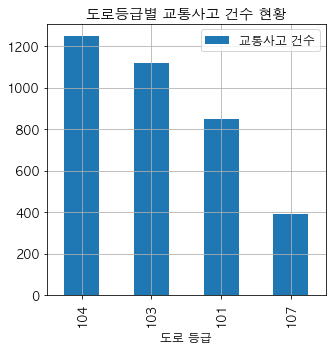

In [105]:
road_sago_cnt.plot(x = '도로 등급', y = '교통사고 건수', kind='bar', legend = True)

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.grid()
plt.title('도로등급별 교통사고 건수 현황')
plt.show()

In [52]:
pop_topis = final_data.iloc[:, np.r_[80:104, 104:128, -1]]

In [53]:
pop_topis.shape

(664178, 49)

In [54]:
pop = final_data.iloc[:, 80:104]
pop_median = pd.DataFrame(pop.median().reset_index())
pop_median.columns = ['유동인구 시간대', '유동인구 중앙값']
pop_median.head()

,유동인구 시간대,유동인구 중앙값
0,pop_0시,74.16000
1,pop_1시,70.01837
2,pop_2시,68.40775
3,pop_3시,67.50461
4,pop_4시,68.03000


In [55]:
topis = final_data.iloc[:, 104:128]
topis_median = pd.DataFrame(topis.median().reset_index())
topis_median.columns = ['구간별 속도 시간대', '구간별 속도 중앙값']
topis_median.head()

,구간별 속도 시간대,구간별 속도 중앙값
0,topis_0시,28.84000
1,topis_1시,30.18000
2,topis_2시,31.32000
3,topis_3시,32.28000
4,topis_4시,32.57000


In [56]:
pop_topis_median = pd.concat([pop_median, topis_median], axis = 1)
pop_topis_median.head()

,유동인구 시간대,유동인구 중앙값,구간별 속도 시간대,구간별 속도 중앙값
0,pop_0시,74.16000,topis_0시,28.84000
1,pop_1시,70.01837,topis_1시,30.18000
2,pop_2시,68.40775,topis_2시,31.32000
3,pop_3시,67.50461,topis_3시,32.28000
4,pop_4시,68.03000,topis_4시,32.57000


In [57]:
pop_topis_median = pop_topis_median.drop(['유동인구 시간대', '구간별 속도 시간대'], axis = 1)

In [58]:
pop_topis_median.head()

,유동인구 중앙값,구간별 속도 중앙값
0,74.16000,28.84000
1,70.01837,30.18000
2,68.40775,31.32000
3,67.50461,32.28000
4,68.03000,32.57000


Text(0.5, 1.0, '시간대별 유동인구 및 구간별 속도 중앙값 현황')

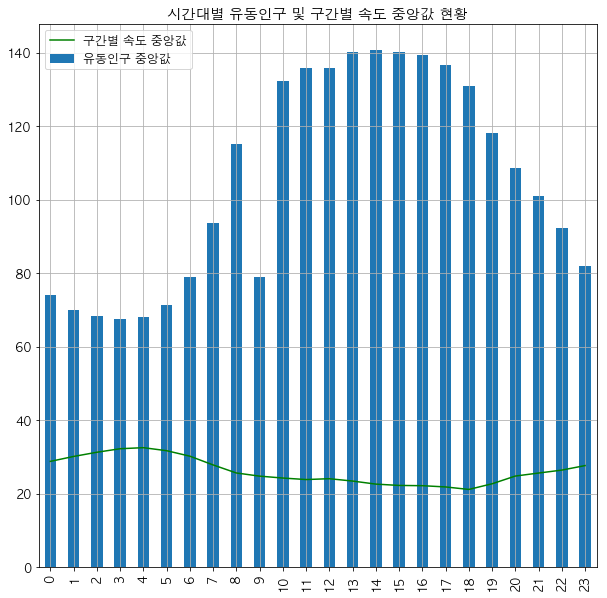

In [59]:
_, ax = plt.subplots()

pop_topis_median.iloc[:,1].plot(kind = 'line', ax=ax, color = 'green', legend = True)
pop_topis_median.iloc[:,0].plot(kind='bar', ax=ax, color = '#1f77b4', legend = True)
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.grid()
plt.title('시간대별 유동인구 및 구간별 속도 중앙값 현황')

In [60]:
pop_topis.iloc[:, 0:24].describe()

,pop_0시,pop_1시,pop_2시,pop_3시,pop_4시,pop_5시,pop_6시,pop_7시,pop_8시,pop_9시,...,pop_14시,pop_15시,pop_16시,pop_17시,pop_18시,pop_19시,pop_20시,pop_21시,pop_22시,pop_23시
count,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,...,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000
mean,108.54341,103.60941,101.81575,100.57459,100.70758,103.54352,111.70130,127.37007,157.37756,111.60749,...,203.67386,203.58445,202.15997,199.10856,193.94914,174.23323,156.35781,143.87797,131.62627,118.03080
std,107.58300,103.57776,102.18845,100.91666,100.53647,101.23104,106.49430,116.96676,144.93862,106.45822,...,197.40147,197.66066,196.08189,193.60292,192.72981,172.81722,152.69403,140.09155,129.20382,116.21716
min,0.00000,0.00000,0.00000,0.00000,0.00333,0.00333,0.00250,0.00000,0.00000,0.00250,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,32.40000,30.39600,29.57073,29.18585,29.56000,31.73500,35.73206,42.66571,49.65617,35.67814,...,56.19250,56.23687,56.22606,55.59019,53.68644,49.37667,45.64600,42.65606,39.25000,35.42500
50%,74.16000,70.01837,68.40775,67.50461,68.03000,71.45056,79.06100,93.63800,115.28414,78.97354,...,140.80517,140.29721,139.27000,136.62115,130.80268,118.23583,108.53868,100.97400,92.34808,81.85789
75%,151.16438,144.14512,141.57542,139.89969,140.06321,144.13667,155.72984,178.25333,223.71167,155.58944,...,287.67750,287.62313,286.67681,282.82176,272.30250,245.57500,221.89765,202.79750,183.40167,164.98458
max,1191.75111,1210.38000,1203.55000,1160.09000,1080.35250,1245.50500,1316.61500,1348.07250,1683.65500,1316.61500,...,1544.27231,1699.87846,1854.32462,1944.16462,1948.46000,1864.04462,1751.14000,1659.35846,1483.74000,1283.87077


# 시간대별 유동인구 분포 - right skewed (좌로 치우침) mean > median

In [61]:
pop_topis.iloc[:, 0:24].median()

pop_0시     74.16000
pop_1시     70.01837
pop_2시     68.40775
pop_3시     67.50461
pop_4시     68.03000
pop_5시     71.45056
pop_6시     79.06100
pop_7시     93.63800
pop_8시    115.28414
pop_9시     78.97354
pop_10시   132.30292
pop_11시   135.83819
pop_12시   135.91464
pop_13시   140.30250
pop_14시   140.80517
pop_15시   140.29721
pop_16시   139.27000
pop_17시   136.62115
pop_18시   130.80268
pop_19시   118.23583
pop_20시   108.53868
pop_21시   100.97400
pop_22시    92.34808
pop_23시    81.85789
dtype: float64

In [73]:
'''pop_topis['pop_22_07시'] = (pop_topis['pop_22시'] + pop_topis['pop_23시'] + pop_topis['pop_0시'] + pop_topis['pop_1시'] + pop_topis['pop_2시'] +
                        pop_topis['pop_3시'] + pop_topis['pop_4시'] + pop_topis['pop_5시'] + pop_topis['pop_6시']) / 9
pop_topis['pop_07_09시'] = (pop_topis['pop_7시'] + pop_topis['pop_8시']) / 2
pop_topis['pop_09_19시'] = (pop_topis['pop_9시'] + pop_topis['pop_10시'] + pop_topis['pop_11시'] + pop_topis['pop_12시'] +
                          pop_topis['pop_13시'] + pop_topis['pop_14시'] + pop_topis['pop_15시'] + pop_topis['pop_16시'] + 
                          pop_topis['pop_17시'] + pop_topis['pop_18시']) / 10
pop_topis['pop_19_22시'] = (pop_topis['pop_19시'] + pop_topis['pop_20시'] + pop_topis['pop_21시']) / 3'''

final_data['pop_22_07시'] = (final_data['pop_22시'] + final_data['pop_23시'] + final_data['pop_0시'] + final_data['pop_1시'] + final_data['pop_2시'] +
                        final_data['pop_3시'] + final_data['pop_4시'] + final_data['pop_5시'] + final_data['pop_6시']) / 9
final_data['pop_07_09시'] = (final_data['pop_7시'] + final_data['pop_8시']) / 2
final_data['pop_09_19시'] = (final_data['pop_9시'] + final_data['pop_10시'] + final_data['pop_11시'] + final_data['pop_12시'] +
                          final_data['pop_13시'] + final_data['pop_14시'] + final_data['pop_15시'] + final_data['pop_16시'] +
                          final_data['pop_17시'] + final_data['pop_18시']) / 10
final_data['pop_19_22시'] = (final_data['pop_19시'] + final_data['pop_20시'] + final_data['pop_21시']) / 3

# 시간대별 구간별 속도 분포 - right skewed (좌로 치우침) mean > median

In [65]:
pop_topis.iloc[:, 24:48].median()

topis_0시    28.84000
topis_1시    30.18000
topis_2시    31.32000
topis_3시    32.28000
topis_4시    32.57000
topis_5시    31.75000
topis_6시    30.26000
topis_7시    27.88000
topis_8시    25.69000
topis_9시    24.83000
topis_10시   24.31000
topis_11시   23.90000
topis_12시   24.13000
topis_13시   23.49000
topis_14시   22.66000
topis_15시   22.30000
topis_16시   22.23000
topis_17시   21.89000
topis_18시   21.21000
topis_19시   22.75000
topis_20시   24.85000
topis_21시   25.67000
topis_22시   26.47000
topis_23시   27.70000
dtype: float64

In [74]:
'''pop_topis['topis_22_07시'] = (pop_topis['topis_22시'] + pop_topis['topis_23시'] + pop_topis['topis_0시'] + pop_topis['topis_1시'] + pop_topis['topis_2시'] +
                        pop_topis['topis_3시'] + pop_topis['topis_4시'] + pop_topis['topis_5시'] + pop_topis['topis_6시']) / 9
pop_topis['topis_07_09시'] = (pop_topis['topis_7시'] + pop_topis['topis_8시']) / 2
pop_topis['topis_09_19시'] = (pop_topis['topis_9시'] + pop_topis['topis_10시'] + pop_topis['topis_11시'] + pop_topis['topis_12시'] +
                          pop_topis['topis_13시'] + pop_topis['topis_14시'] + pop_topis['topis_15시'] + pop_topis['topis_16시'] +
                          pop_topis['topis_17시'] + pop_topis['topis_18시']) / 10
pop_topis['topis_19_22시'] = (pop_topis['topis_19시'] + pop_topis['topis_20시'] + pop_topis['topis_21시']) / 3'''

final_data['topis_22_07시'] = (final_data['topis_22시'] + final_data['topis_23시'] + final_data['topis_0시'] + final_data['topis_1시'] + final_data['topis_2시'] +
                        final_data['topis_3시'] + final_data['topis_4시'] + final_data['topis_5시'] + final_data['topis_6시']) / 9
final_data['topis_07_09시'] = (final_data['topis_7시'] + final_data['topis_8시']) / 2
final_data['topis_09_19시'] = (final_data['topis_9시'] + final_data['topis_10시'] + final_data['topis_11시'] + final_data['topis_12시'] +
                          final_data['topis_13시'] + final_data['topis_14시'] + final_data['topis_15시'] + final_data['topis_16시'] +
                          final_data['topis_17시'] + final_data['topis_18시']) / 10
final_data['topis_19_22시'] = (final_data['topis_19시'] + final_data['topis_20시'] + final_data['topis_21시']) / 3

In [ ]:
pop_topis_cat = pop_topis[['pop_22_07시', 'pop_07_09시', 'pop_09_19시', 'pop_19_22시', 'topis_22_07시', 'topis_07_09시', 'topis_09_19시',
                           'topis_19_22시', 'SAGO_YN']]

In [261]:
pop_topis_cat.corr(method = 'pearson')

,pop_22_07시,pop_07_09시,pop_09_19시,pop_19_22시,topis_22_07시,topis_07_09시,topis_09_19시,topis_19_22시
pop_22_07시,1.00000,0.87576,0.71227,0.86965,-0.29033,-0.23102,-0.29812,-0.29553
pop_07_09시,0.87576,1.00000,0.87689,0.89368,-0.31379,-0.29823,-0.36278,-0.34557
pop_09_19시,0.71227,0.87689,1.00000,0.91899,-0.34224,-0.30693,-0.42025,-0.39174
pop_19_22시,0.86965,0.89368,0.91899,1.00000,-0.34168,-0.28546,-0.39063,-0.38321
topis_22_07시,-0.29033,-0.31379,-0.34224,-0.34168,1.00000,0.78181,0.80333,0.84155
topis_07_09시,-0.23102,-0.29823,-0.30693,-0.28546,0.78181,1.00000,0.83599,0.76658
topis_09_19시,-0.29812,-0.36278,-0.42025,-0.39063,0.80333,0.83599,1.00000,0.90360
topis_19_22시,-0.29553,-0.34557,-0.39174,-0.38321,0.84155,0.76658,0.90360,1.00000


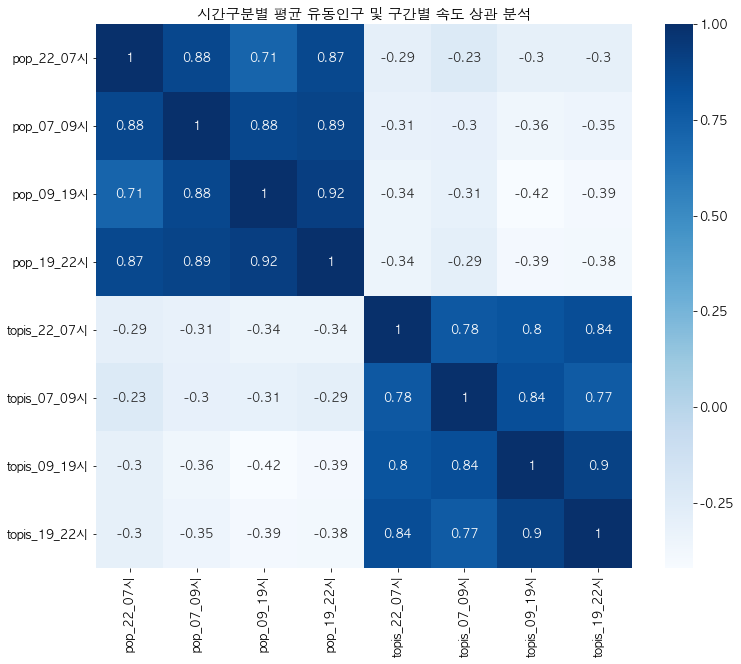

In [262]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = pop_topis_cat.corr(method = 'pearson')
sns.heatmap(cor, annot=True, cmap= 'Blues')

plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.title('시간구분별 평균 유동인구 및 구간별 속도 상관 분석')
plt.show()

# 도로환경변수 (CNT 변수) - 교통사고 예측 분석 (Grid Search  Weighted Logistic Regression)

In [742]:
category_final_data_cnt = final_data[['BUS_CNT', 'SUB_CNT', 'CW_CNT', 'HUMP_CNT',
                                 'A3_ROADTYPE_1_CNT', 'A3_ROADTYPE_2_CNT', 'A3_ROADTYPE_3_CNT',
                                 'A3_ROADTYPE_4_CNT', 'A3_ROADTYPE_5_CNT', 'A3_ROADTYPE_6_CNT',
                                  'A1_LANE_02_CNT', 'A1_LANE_04_CNT', 'A1_LANE_10_CNT', 'A1_LANE_12_CNT',
                                  'A1_BARR_02_CNT', 'A1_BARR_03_CNT', 'A1_BARR_05_CNT',
                                  'A2_STOP_1_CNT', 'A2_STOP_2_CNT', 'S_P_KIDS_CNT', 'S_P_BIKE_CNT', 'S_P_UTERN_CNT', 'S_P_UTERNX_CNT',
                                  'SN_P_HDUFID_CNT', 'SF_P_ALL_CNT', 'SF_P_UTERN_CNT', 'SF_L_ALL_CNT', 'SF_L_1_CNT', 'SF_L_2_CNT',
                                  'SF_PL_CW_CNT', 'SF_PL_HUMP_CNT', 'SF_PL_BIKE_CW_CNT', 'NODE_INTER_CNT', 'NODE_INTERS_CNT', 'NODE_ROTARY_CNT',
                                   'NODE_LANES_CNT', 'NODE_ALL_CNT', 'SAGO_YN'
                                 ]]

In [743]:
category_final_data_cnt['SAGO_YN'] = category_final_data_cnt.apply(lambda x: 1 if x['SAGO_YN'] == 'Y' else 0, axis = 1)

/Users/wbchoi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [744]:
category_final_data_cnt['SAGO_YN'].value_counts()

0    660573
1      3605
Name: SAGO_YN, dtype: int64

# 도로환경변수 (CNT 변수) - 교통사고 예측 분석 (Logistic Regression 기반 변수 중요도 도출)

In [750]:
x = category_final_data_cnt.iloc[:, 0:-1]
y = category_final_data_cnt.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# 표준화: 평균 0, 분산 1
sc = StandardScaler()
x_std = sc.fit_transform(x_train)
print(x_std)

weights = {0:1.0, 1: 1000.0}

# define model
# model = LogisticRegression(random_state = 0, class_weight = 'balanced', solver = 'lbfgs')
# model = LogisticRegression(random_state = 0, class_weight = weights, solver = 'lbfgs')
model = LogisticRegression(random_state = 777, solver = 'lbfgs')

# fit the model
model.fit(x_std, y_train)

[[-1.23603595 -0.49853863  2.19310958 ... -0.06056243 -0.4400948
  -0.04545455]
 [-0.48597806 -0.49853863 -1.01163178 ... -0.06056243 -0.4400948
  -0.04545455]
 [-0.861007   -0.49853863 -1.01163178 ... -0.06056243 -0.4400948
  -0.02950195]
 ...
 [-1.23603595 -0.49853863 -1.01163178 ... -0.06056243  0.94804103
   0.02899093]
 [-0.11094912 -0.49853863 -0.21044644 ... -0.06056243 -0.4400948
  -0.04545455]
 [-0.48597806  1.9660549  -0.21044644 ... -0.06056243 -0.4400948
  -0.04545455]]


/Users/wbchoi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=777, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [751]:
# get importance
importance = abs(model.coef_[0])

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.12374
Feature: 1, Score: 0.06011
Feature: 2, Score: 0.13803
Feature: 3, Score: 0.04975
Feature: 4, Score: 3.07278
Feature: 5, Score: 0.11372
Feature: 6, Score: 0.01528
Feature: 7, Score: 0.01950
Feature: 8, Score: 0.02595
Feature: 9, Score: 0.20699
Feature: 10, Score: 0.06378
Feature: 11, Score: 0.24141
Feature: 12, Score: 0.04317
Feature: 13, Score: 0.17932
Feature: 14, Score: 0.09465
Feature: 15, Score: 0.01999
Feature: 16, Score: 0.03792
Feature: 17, Score: 0.09557
Feature: 18, Score: 3.14569
Feature: 19, Score: 0.02419
Feature: 20, Score: 0.02999
Feature: 21, Score: 0.01123
Feature: 22, Score: 0.05884
Feature: 23, Score: 0.78824
Feature: 24, Score: 3.58952
Feature: 25, Score: 0.05189
Feature: 26, Score: 0.05210
Feature: 27, Score: 0.05210
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.01313
Feature: 30, Score: 0.00237
Feature: 31, Score: 0.00861
Feature: 32, Score: 1.36448
Feature: 33, Score: 1.36440
Feature: 34, Score: 0.05400
Feature: 35, Score: 0.05789
Fe

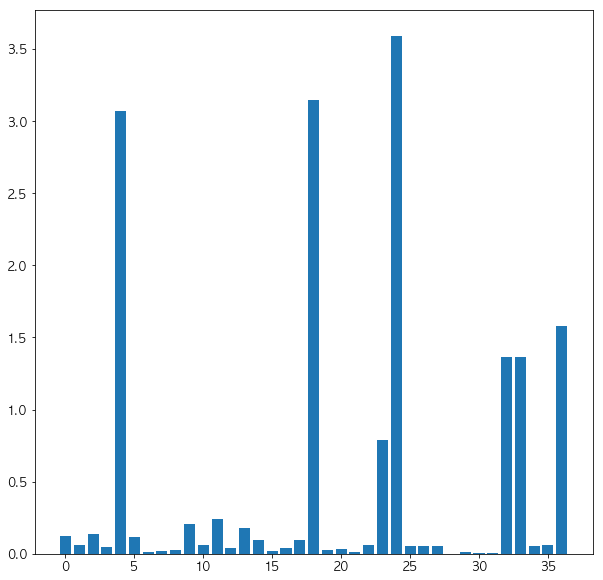

In [752]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.rcParams['axes.unicode_minus'] = False
plt.show()

In [753]:
feature_importance = 100.0 * (importance / importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

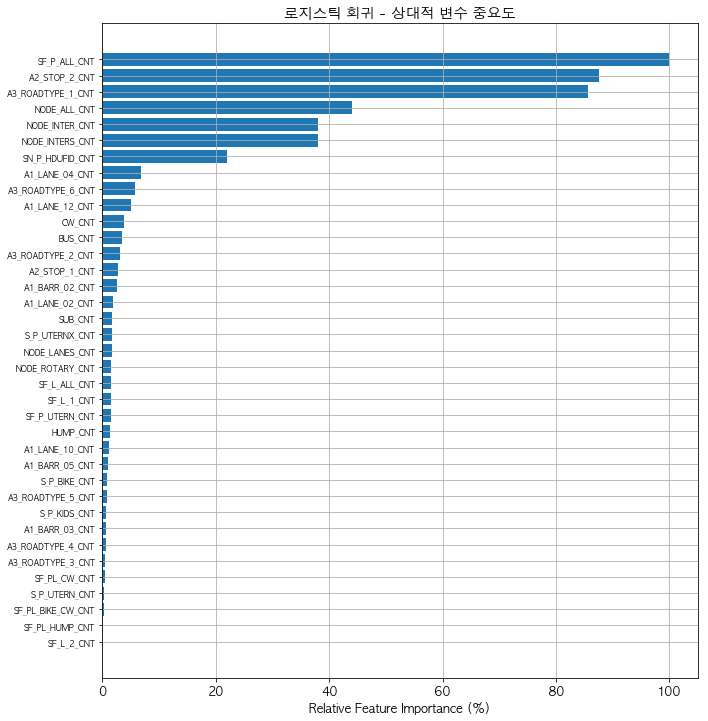

In [754]:
featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance (%)')

plt.tight_layout()
# plt.title('로지스틱 회귀 - 상대적 변수 중요도 (교통사고 유:무 = 1000:1 샘플링)')
plt.title('로지스틱 회귀 - 상대적 변수 중요도')

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.grid()
plt.show()

# 시간구분별 유동인구,  TOPIS-소통정보, 기상정보 - 교통사고 예측분석 (가설 검정)

In [801]:
pop_topis_kma = pd.DataFrame()

In [802]:
pop_topis_kma['pop_22_07시'] = (final_data['pop_22시'] + final_data['pop_23시'] + final_data['pop_0시'] + final_data['pop_1시'] + final_data['pop_2시'] +
                        final_data['pop_3시'] + final_data['pop_4시'] + final_data['pop_5시'] + final_data['pop_6시']) / 9
pop_topis_kma['pop_07_09시'] = (final_data['pop_7시'] + final_data['pop_8시']) / 2
pop_topis_kma['pop_09_19시'] = (final_data['pop_9시'] + final_data['pop_10시'] + final_data['pop_11시'] + final_data['pop_12시'] +
                          final_data['pop_13시'] + final_data['pop_14시'] + final_data['pop_15시'] + final_data['pop_16시'] +
                          +final_data['pop_17시'] + final_data['pop_18시']) / 10
pop_topis_kma['pop_19_22시'] = (final_data['pop_19시'] + final_data['pop_20시'] + final_data['pop_21시']) / 3

In [803]:
pop_topis_kma['topis_22_07시'] = (final_data['topis_22시'] + final_data['topis_23시'] + final_data['topis_0시'] + final_data['topis_1시'] + final_data['topis_2시'] +
                        final_data['topis_3시'] + final_data['topis_4시'] + final_data['topis_5시'] + final_data['topis_6시']) / 9
pop_topis_kma['topis_07_09시'] = (final_data['topis_7시'] + final_data['topis_8시']) / 2
pop_topis_kma['topis_09_19시'] = (final_data['topis_9시'] + final_data['topis_10시'] + final_data['topis_11시'] + final_data['topis_12시'] +
                          final_data['topis_13시'] + final_data['topis_14시'] + final_data['topis_15시'] + final_data['topis_16시'] +
                          +final_data['topis_17시'] + final_data['topis_18시']) / 10
pop_topis_kma['topis_19_22시'] = (final_data['topis_19시'] + final_data['topis_20시'] + final_data['topis_21시']) / 3

In [804]:
pop_topis_kma['TEMP'] = final_data['TEMP']
pop_topis_kma['HM'] = final_data['HM']
pop_topis_kma['RF'] = final_data['RF']
pop_topis_kma['WD'] = final_data['WD']
pop_topis_kma['WS'] = final_data['WS']
pop_topis_kma['SAGO_YN'] = final_data['SAGO_YN']

In [805]:
pop_topis_kma.head()

,pop_22_07시,pop_07_09시,pop_09_19시,pop_19_22시,topis_22_07시,topis_07_09시,topis_09_19시,topis_19_22시,TEMP,HM,RF,WD,WS,SAGO_YN
0,25.60313,24.93281,40.05531,37.09042,34.73111,40.13500,21.24500,25.97667,0.05217,43.57391,0.00000,238.74783,1.39565,N
1,27.08993,76.92781,129.45788,59.85063,36.44889,23.96500,20.31700,23.32333,-0.62083,50.27500,0.00000,275.63750,2.27083,N
2,28.85729,75.24281,131.00294,57.49083,35.76222,24.81000,19.88900,22.51333,-3.84167,46.32500,0.00000,301.15833,3.12083,N
3,29.46361,74.22156,129.02338,60.48896,34.82000,23.62500,20.18900,23.27000,-4.26667,48.38333,0.00000,260.13750,2.02500,N
4,30.14875,75.39344,127.54294,69.82729,36.54889,25.04500,18.59600,12.21333,-2.05000,52.32083,0.00000,319.78750,1.87917,N


In [806]:
pop_topis_kma.describe()

,pop_22_07시,pop_07_09시,pop_09_19시,pop_19_22시,topis_22_07시,topis_07_09시,topis_09_19시,topis_19_22시,TEMP,HM,RF,WD,WS
count,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000,664178.00000
mean,108.90585,142.37381,188.81486,158.15634,31.61562,27.71120,23.83946,25.16541,12.14367,58.29604,0.10613,191.42595,1.77433
std,105.87213,128.68960,177.14699,154.12335,9.18328,8.42066,7.85595,8.02635,10.67260,10.31958,0.42354,66.04745,0.83886
min,0.00222,0.00000,0.00050,0.00000,7.35333,4.16500,2.85800,2.77667,-19.87917,-99.90000,0.00000,0.00000,0.00000
25%,33.73611,46.84564,54.86366,46.33212,26.80111,23.36000,19.32300,20.75333,3.71250,57.80833,0.00000,144.12500,1.18333
50%,75.96571,105.50964,133.50167,109.61217,30.15222,26.78500,23.09500,24.42333,12.72083,57.80833,0.00000,191.72917,1.59167
75%,151.48200,203.45797,270.93121,224.42993,33.75889,30.47000,26.69500,28.18000,21.24583,57.80833,0.00000,239.15417,2.14583
max,1039.28444,1287.14125,1406.68908,1754.62923,108.50000,110.87500,90.42500,90.55667,34.35000,99.59583,7.87500,351.20000,6.84091


In [807]:
pop_topis_kma.fillna(pop_topis_kma.median())

,pop_22_07시,pop_07_09시,pop_09_19시,pop_19_22시,topis_22_07시,topis_07_09시,topis_09_19시,topis_19_22시,TEMP,HM,RF,WD,WS,SAGO_YN
0,25.60313,24.93281,40.05531,37.09042,34.73111,40.13500,21.24500,25.97667,0.05217,43.57391,0.00000,238.74783,1.39565,N
1,27.08993,76.92781,129.45788,59.85063,36.44889,23.96500,20.31700,23.32333,-0.62083,50.27500,0.00000,275.63750,2.27083,N
2,28.85729,75.24281,131.00294,57.49083,35.76222,24.81000,19.88900,22.51333,-3.84167,46.32500,0.00000,301.15833,3.12083,N
3,29.46361,74.22156,129.02338,60.48896,34.82000,23.62500,20.18900,23.27000,-4.26667,48.38333,0.00000,260.13750,2.02500,N
4,30.14875,75.39344,127.54294,69.82729,36.54889,25.04500,18.59600,12.21333,-2.05000,52.32083,0.00000,319.78750,1.87917,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664173,135.73582,125.63441,94.36059,109.84569,30.15222,26.78500,23.09500,24.42333,24.73750,57.80833,0.00000,130.85000,1.00000,N
664174,135.07595,125.18441,90.25371,108.91922,30.15222,26.78500,23.09500,24.42333,24.95833,57.80833,0.02083,144.72083,1.00833,N
664175,134.31013,125.60059,90.52788,108.86431,30.15222,26.78500,23.09500,24.42333,24.28333,57.80833,0.00000,187.62083,0.75833,N
664176,144.38725,141.13676,118.76588,116.72039,30.15222,26.78500,23.09500,24.42333,21.95000,57.80833,0.04167,78.75833,1.15833,N


In [808]:
pop_topis_kma['SAGO_YN'] = pop_topis_kma.apply(lambda x: 1 if x['SAGO_YN'] == 'Y' else 0, axis = 1)

In [809]:
pop_topis_kma['SAGO_YN'].value_counts()

0    660573
1      3605
Name: SAGO_YN, dtype: int64

In [810]:
X = pop_topis_kma.iloc[:, 0:-1]
Y = pop_topis_kma.iloc[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# 표준화: 평균 0, 분산 1
sc = StandardScaler()
X_std = sc.fit_transform(X_train)
print(X_std)

# weights = {0:1.0, 1: 1000.0}

# define model
# model = LogisticRegression(random_state = 0, class_weight = 'balanced', solver = 'lbfgs')
# model = LogisticRegression(random_state = 0, class_weight = weights, solver = 'lbfgs')
model = LogisticRegression(random_state = 777, solver = 'lbfgs')

# fit the model
model.fit(X_std, Y_train)

[[-0.98008223 -1.043719   -0.98101709 ... -0.25091304  0.81567545
  -0.43240731]
 [-0.01969067 -0.26680852 -0.39586413 ... -0.25091304  2.03575472
   1.55892959]
 [-0.64744975 -0.76677175 -0.86248077 ... -0.25091304  1.11298342
  -0.83464743]
 ...
 [-0.83474034 -0.81800009 -0.69330764 ... -0.25091304  0.00752511
   0.08404914]
 [-0.83879774 -0.3493748  -0.4059445  ... -0.20152291  0.75738718
   1.22621245]
 [ 0.90609131  2.33939099  1.4206288  ... -0.25091304  1.01028506
   0.55581225]]


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=777, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [811]:
X.head()

,pop_22_07시,pop_07_09시,pop_09_19시,pop_19_22시,topis_22_07시,topis_07_09시,topis_09_19시,topis_19_22시,TEMP,HM,RF,WD,WS
0,25.60313,24.93281,40.05531,37.09042,34.73111,40.13500,21.24500,25.97667,0.05217,43.57391,0.00000,238.74783,1.39565
1,27.08993,76.92781,129.45788,59.85063,36.44889,23.96500,20.31700,23.32333,-0.62083,50.27500,0.00000,275.63750,2.27083
2,28.85729,75.24281,131.00294,57.49083,35.76222,24.81000,19.88900,22.51333,-3.84167,46.32500,0.00000,301.15833,3.12083
3,29.46361,74.22156,129.02338,60.48896,34.82000,23.62500,20.18900,23.27000,-4.26667,48.38333,0.00000,260.13750,2.02500
4,30.14875,75.39344,127.54294,69.82729,36.54889,25.04500,18.59600,12.21333,-2.05000,52.32083,0.00000,319.78750,1.87917


In [812]:
# get importance
importance = abs(model.coef_[0])

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01727
Feature: 1, Score: 0.07176
Feature: 2, Score: 0.17688
Feature: 3, Score: 0.32167
Feature: 4, Score: 0.66466
Feature: 5, Score: 0.01459
Feature: 6, Score: 0.24691
Feature: 7, Score: 0.05598
Feature: 8, Score: 0.11663
Feature: 9, Score: 0.00128
Feature: 10, Score: 0.02130
Feature: 11, Score: 0.01586
Feature: 12, Score: 0.13634


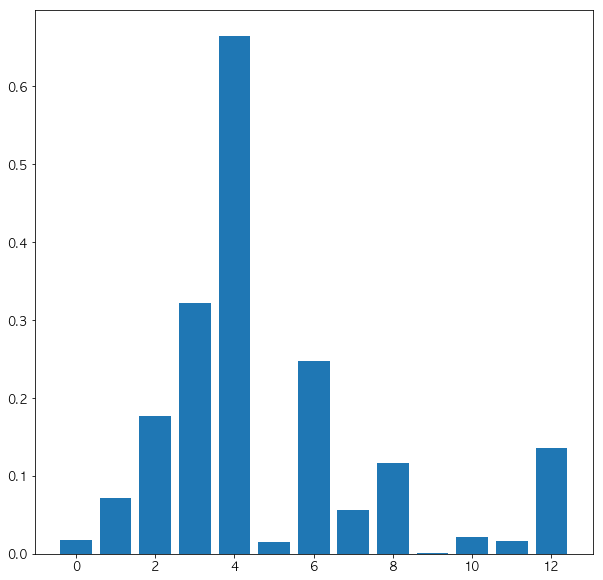

In [813]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.rcParams['axes.unicode_minus'] = False
plt.show()

In [814]:
feature_importance = 100.0 * (importance / importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

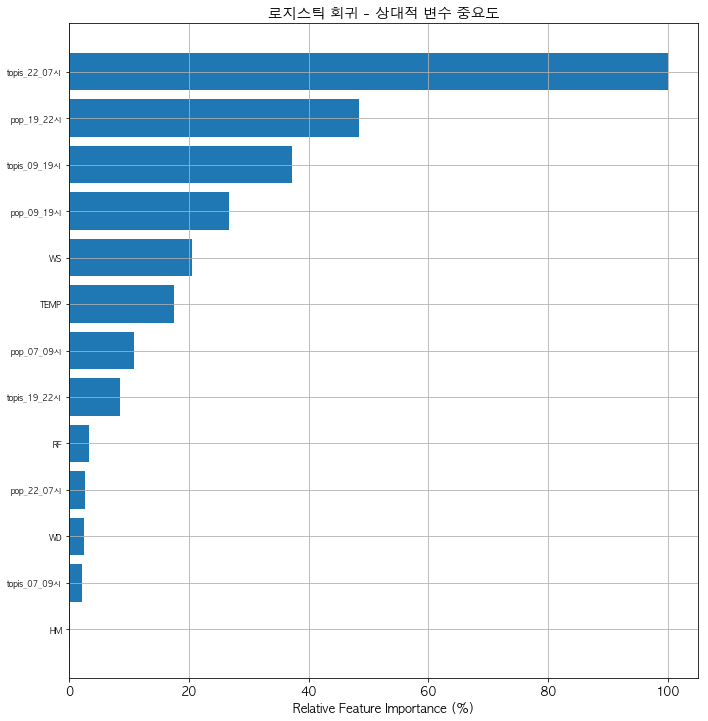

In [815]:
featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance (%)')

plt.tight_layout()
# plt.title('로지스틱 회귀 - 상대적 변수 중요도 (교통사고 유:무 = 1000:1 샘플링)')
plt.title('로지스틱 회귀 - 상대적 변수 중요도')

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.grid()
plt.show()

# Auto Feature Selection 

In [75]:
eda_final_data = final_data[['ROAD_TYPE', 'LANES', 'MAX_SPD', 'ROAD_USE', 'MULTI_LINK', 'REST_VEH', 'CONNECT_101_YN', 
                             'BUS_YN', 'SUB_YN', 'CW_YN', 'HUMP_YN',
                                 'A3_ROADTYPE_1_YN', 'A3_ROADTYPE_2_YN', 'A3_ROADTYPE_3_YN',
                                 'A3_ROADTYPE_4_YN', 'A3_ROADTYPE_5_YN', 'A3_ROADTYPE_6_YN',
                                  'A1_LANE_02_YN', 'A1_LANE_04_YN', 'A1_LANE_10_YN', 'A1_LANE_12_YN',
                                  'A1_BARR_02_YN', 'A1_BARR_03_YN', 'A1_BARR_05_YN',
                                  'A2_STOP_1_YN', 'A2_STOP_2_YN', 'S_P_KIDS_YN', 'S_P_BIKE_YN', 'S_P_UTERN_YN', 'S_P_UTERNX_YN',
                                  'SN_P_HDUFID_YN', 'SF_P_ALL_YN', 'SF_P_UTERN_YN', 'SF_L_ALL_YN', 'SF_L_1_YN', 'SF_L_2_YN',
                                  'SF_PL_CW_YN', 'SF_PL_HUMP_YN', 'SF_PL_BIKE_CW_YN', 'NODE_INTER_YN', 'NODE_INTERS_YN', 'NODE_ROTARY_YN',
                                   'NODE_LANES_YN', 'NODE_ALL_YN','ROAD_RANK_101_YN', 'GONGSA_YN',
                                  'BUS_CNT', 'SUB_CNT', 'CW_CNT', 'HUMP_CNT',
                                 'A3_ROADTYPE_1_CNT', 'A3_ROADTYPE_2_CNT', 'A3_ROADTYPE_3_CNT',
                                 'A3_ROADTYPE_4_CNT', 'A3_ROADTYPE_5_CNT', 'A3_ROADTYPE_6_CNT',
                                  'A1_LANE_02_CNT', 'A1_LANE_04_CNT', 'A1_LANE_10_CNT', 'A1_LANE_12_CNT',
                                  'A1_BARR_02_CNT', 'A1_BARR_03_CNT', 'A1_BARR_05_CNT',
                                  'A2_STOP_1_CNT', 'A2_STOP_2_CNT', 'S_P_KIDS_CNT', 'S_P_BIKE_CNT', 'S_P_UTERN_CNT', 'S_P_UTERNX_CNT',
                                  'SN_P_HDUFID_CNT', 'SF_P_ALL_CNT', 'SF_P_UTERN_CNT', 'SF_L_ALL_CNT', 'SF_L_1_CNT', 'SF_L_2_CNT',
                                  'SF_PL_CW_CNT', 'SF_PL_HUMP_CNT', 'SF_PL_BIKE_CW_CNT', 'NODE_INTER_CNT', 'NODE_INTERS_CNT', 'NODE_ROTARY_CNT',
                                   'NODE_LANES_CNT', 'NODE_ALL_CNT', 'pop_09_19시', 'pop_19_22시', 'pop_22_07시', 'pop_07_09시',
                                   'topis_09_19시', 'topis_19_22시', 'topis_22_07시', 'topis_07_09시', 'WS', 'TEMP', 'HM', 'RF', 'WD',
                                    'SAGO_YN']]

In [76]:
eda_final_data.rename(columns = {'pop_09_19시': 'pop_09_19',
                                             'pop_19_22시': 'pop_19_22',
                                             'pop_22_07시': 'pop_22_07',
                                             'pop_07_09시': 'pop_07_09',
                                             'topis_09_19시': 'topis_09_19',
                                             'topis_19_22시': 'topis_19_22',
                                             'topis_22_07시': 'topis_22_07',
                                             'topis_07_09시': 'topis_07_09'
                                            }, inplace = True)

/Users/wbchoi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [77]:
eda_final_data.columns

Index(['ROAD_TYPE', 'LANES', 'MAX_SPD', 'ROAD_USE', 'MULTI_LINK', 'REST_VEH',
       'CONNECT_101_YN', 'BUS_YN', 'SUB_YN', 'CW_YN', 'HUMP_YN',
       'A3_ROADTYPE_1_YN', 'A3_ROADTYPE_2_YN', 'A3_ROADTYPE_3_YN',
       'A3_ROADTYPE_4_YN', 'A3_ROADTYPE_5_YN', 'A3_ROADTYPE_6_YN',
       'A1_LANE_02_YN', 'A1_LANE_04_YN', 'A1_LANE_10_YN', 'A1_LANE_12_YN',
       'A1_BARR_02_YN', 'A1_BARR_03_YN', 'A1_BARR_05_YN', 'A2_STOP_1_YN',
       'A2_STOP_2_YN', 'S_P_KIDS_YN', 'S_P_BIKE_YN', 'S_P_UTERN_YN',
       'S_P_UTERNX_YN', 'SN_P_HDUFID_YN', 'SF_P_ALL_YN', 'SF_P_UTERN_YN',
       'SF_L_ALL_YN', 'SF_L_1_YN', 'SF_L_2_YN', 'SF_PL_CW_YN', 'SF_PL_HUMP_YN',
       'SF_PL_BIKE_CW_YN', 'NODE_INTER_YN', 'NODE_INTERS_YN', 'NODE_ROTARY_YN',
       'NODE_LANES_YN', 'NODE_ALL_YN', 'ROAD_RANK_101_YN', 'GONGSA_YN',
       'BUS_CNT', 'SUB_CNT', 'CW_CNT', 'HUMP_CNT', 'A3_ROADTYPE_1_CNT',
       'A3_ROADTYPE_2_CNT', 'A3_ROADTYPE_3_CNT', 'A3_ROADTYPE_4_CNT',
       'A3_ROADTYPE_5_CNT', 'A3_ROADTYPE_6_CNT', 'A1_LANE

In [78]:
eda_final_data.iloc[:, 46:96].columns

Index(['BUS_CNT', 'SUB_CNT', 'CW_CNT', 'HUMP_CNT', 'A3_ROADTYPE_1_CNT',
       'A3_ROADTYPE_2_CNT', 'A3_ROADTYPE_3_CNT', 'A3_ROADTYPE_4_CNT',
       'A3_ROADTYPE_5_CNT', 'A3_ROADTYPE_6_CNT', 'A1_LANE_02_CNT',
       'A1_LANE_04_CNT', 'A1_LANE_10_CNT', 'A1_LANE_12_CNT', 'A1_BARR_02_CNT',
       'A1_BARR_03_CNT', 'A1_BARR_05_CNT', 'A2_STOP_1_CNT', 'A2_STOP_2_CNT',
       'S_P_KIDS_CNT', 'S_P_BIKE_CNT', 'S_P_UTERN_CNT', 'S_P_UTERNX_CNT',
       'SN_P_HDUFID_CNT', 'SF_P_ALL_CNT', 'SF_P_UTERN_CNT', 'SF_L_ALL_CNT',
       'SF_L_1_CNT', 'SF_L_2_CNT', 'SF_PL_CW_CNT', 'SF_PL_HUMP_CNT',
       'SF_PL_BIKE_CW_CNT', 'NODE_INTER_CNT', 'NODE_INTERS_CNT',
       'NODE_ROTARY_CNT', 'NODE_LANES_CNT', 'NODE_ALL_CNT', 'pop_09_19',
       'pop_19_22', 'pop_22_07', 'pop_07_09', 'topis_09_19', 'topis_19_22',
       'topis_22_07', 'topis_07_09', 'WS', 'TEMP', 'HM', 'RF', 'WD'],
      dtype='object')

In [79]:
# 연속형 변수 및 도로환경변수 (CNT) Min - Max scaling
sc = MinMaxScaler()
eda_final_data.iloc[:, 46:96] = sc.fit_transform(eda_final_data.iloc[:, 46:96])
eda_final_data.iloc[:, 46:96].head()

/Users/wbchoi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,BUS_CNT,SUB_CNT,CW_CNT,HUMP_CNT,A3_ROADTYPE_1_CNT,A3_ROADTYPE_2_CNT,A3_ROADTYPE_3_CNT,A3_ROADTYPE_4_CNT,A3_ROADTYPE_5_CNT,A3_ROADTYPE_6_CNT,...,pop_07_09,topis_09_19,topis_19_22,topis_22_07,topis_07_09,WS,TEMP,HM,RF,WD
0,0.14286,0.00000,0.22222,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.01937,0.20998,0.26430,0.27067,0.33708,0.20402,0.36754,0.71918,0.00000,0.67981
1,0.14286,0.00000,0.22222,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.05977,0.19938,0.23407,0.28766,0.18555,0.33195,0.35513,0.75277,0.00000,0.78484
2,0.14286,0.00000,0.22222,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.05846,0.19449,0.22484,0.28087,0.19347,0.45620,0.29574,0.73297,0.00000,0.85751
3,0.14286,0.00000,0.22222,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.05766,0.19792,0.23346,0.27155,0.18236,0.29601,0.28790,0.74329,0.00000,0.74071
4,0.14286,0.00000,0.22222,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.05857,0.17973,0.10750,0.28865,0.19567,0.27470,0.32877,0.76303,0.00000,0.91056


In [80]:
eda_final_data['SAGO_YN'] = eda_final_data.apply(lambda x: 1 if x['SAGO_YN'] == 'Y' else 0, axis = 1)

/Users/wbchoi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [81]:
eda_final_data['SAGO_YN'].value_counts()

0    660573
1      3605
Name: SAGO_YN, dtype: int64

In [82]:
eda_final_data.iloc[:, 6:46].columns

Index(['CONNECT_101_YN', 'BUS_YN', 'SUB_YN', 'CW_YN', 'HUMP_YN',
       'A3_ROADTYPE_1_YN', 'A3_ROADTYPE_2_YN', 'A3_ROADTYPE_3_YN',
       'A3_ROADTYPE_4_YN', 'A3_ROADTYPE_5_YN', 'A3_ROADTYPE_6_YN',
       'A1_LANE_02_YN', 'A1_LANE_04_YN', 'A1_LANE_10_YN', 'A1_LANE_12_YN',
       'A1_BARR_02_YN', 'A1_BARR_03_YN', 'A1_BARR_05_YN', 'A2_STOP_1_YN',
       'A2_STOP_2_YN', 'S_P_KIDS_YN', 'S_P_BIKE_YN', 'S_P_UTERN_YN',
       'S_P_UTERNX_YN', 'SN_P_HDUFID_YN', 'SF_P_ALL_YN', 'SF_P_UTERN_YN',
       'SF_L_ALL_YN', 'SF_L_1_YN', 'SF_L_2_YN', 'SF_PL_CW_YN', 'SF_PL_HUMP_YN',
       'SF_PL_BIKE_CW_YN', 'NODE_INTER_YN', 'NODE_INTERS_YN', 'NODE_ROTARY_YN',
       'NODE_LANES_YN', 'NODE_ALL_YN', 'ROAD_RANK_101_YN', 'GONGSA_YN'],
      dtype='object')

In [83]:
for i in range(eda_final_data.iloc[:, 6:46].shape[1]):
    eda_final_data.iloc[:, i+6] = eda_final_data.apply(lambda x: 1 if x[i+6] == 'Y' else 0, axis = 1)

/Users/wbchoi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [84]:
cat_X = eda_final_data.iloc[:, 0:83]
num_X = eda_final_data.iloc[:, 83:-1]

X = eda_final_data.iloc[:, 0:-1]
y = eda_final_data.iloc[:, -1]

In [85]:
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

In [86]:
cat_feature_name = cat_X.columns.tolist()
num_feature_name = num_X.columns.tolist()
feature_name = X.columns.tolist()

In [687]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in num_feature_name]
    return cor_support, cor_feature

In [583]:
cor_support, cor_feature = cor_selector(num_X, y)
print(str(len(cor_feature)), 'selected features')

13 selected features


In [584]:
'''Chi - Square 검정'''
chi_selector = SelectKBest(chi2, k=40)
chi_selector.fit(cat_X, y)

SelectKBest(k=40, score_func=<function chi2 at 0x7f819061d598>)

In [585]:
chi_support = chi_selector.get_support()
chi_feature = cat_X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

40 selected features


In [586]:
'''맥니마 검정'''
mcnemar_result_yn = pd.DataFrame(columns = {'칼럼명', '자유도', 'p-value', '맥니마_통계량'})

In [587]:
mcnemar_test_table = final_data[['BUS_YN', 'SUB_YN', 'CW_YN', 'HUMP_YN',
                                 'A3_ROADTYPE_1_YN', 'A3_ROADTYPE_2_YN', 'A3_ROADTYPE_3_YN',
                                 'A3_ROADTYPE_4_YN', 'A3_ROADTYPE_5_YN', 'A3_ROADTYPE_6_YN',
                                  'A1_LANE_02_YN', 'A1_LANE_04_YN', 'A1_LANE_10_YN', 'A1_LANE_12_YN',
                                  'A1_BARR_02_YN', 'A1_BARR_03_YN', 'A1_BARR_05_YN',
                                  'A2_STOP_1_YN', 'A2_STOP_2_YN', 'S_P_KIDS_YN', 'S_P_BIKE_YN', 'S_P_UTERN_YN', 'S_P_UTERNX_YN',
                                  'SN_P_HDUFID_YN', 'SF_P_ALL_YN', 'SF_P_UTERN_YN', 'SF_L_ALL_YN', 'SF_L_1_YN', 'SF_L_2_YN',
                                  'SF_PL_CW_YN', 'SF_PL_HUMP_YN', 'SF_PL_BIKE_CW_YN', 'NODE_INTER_YN', 'NODE_INTERS_YN', 'NODE_ROTARY_YN',
                                   'NODE_LANES_YN', 'NODE_ALL_YN', 'ROAD_RANK_101_YN', 'GONGSA_YN','SAGO_YN'
                                ]]

In [588]:
for i in range(mcnemar_test_table.shape[1] - 1):
    crosstab, test_results = rp.crosstab(mcnemar_test_table.iloc[:, i], mcnemar_test_table.iloc[:, -1],
                                               test= 'mcnemar')
    
    print('칼럼 명 : ', mcnemar_test_table.iloc[:, i:i+1].columns)
    print('자유도 : ', stats.chi2_contingency(crosstab)[2])
    print('맥니마 통계량 : %.3f' %(stats.chi2_contingency(crosstab)[0]))
    
    mcnemar_result_yn.loc[i] = [mcnemar_test_table.iloc[:, i:i+1].columns,
                         stats.chi2_contingency(crosstab)[2],
                         stats.chi2_contingency(crosstab)[1],
                         stats.chi2_contingency(crosstab)[0]
                         ]

칼럼 명 :  Index(['BUS_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 1.186
칼럼 명 :  Index(['SUB_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 64.717
칼럼 명 :  Index(['CW_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 275.054
칼럼 명 :  Index(['HUMP_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 44.596
칼럼 명 :  Index(['A3_ROADTYPE_1_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 1170.897
칼럼 명 :  Index(['A3_ROADTYPE_2_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 20.307
칼럼 명 :  Index(['A3_ROADTYPE_3_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 2272.918
칼럼 명 :  Index(['A3_ROADTYPE_4_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 0.324
칼럼 명 :  Index(['A3_ROADTYPE_5_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 42.783
칼럼 명 :  Index(['A3_ROADTYPE_6_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 2.819
칼럼 명 :  Index(['A1_LANE_02_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 122.501
칼럼 명 :  Index(['A1_LANE_04_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 1206.446
칼럼 명 :  Index(['A1_LANE_10_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 5.521
칼럼 명 :  Index(['A1_LANE_12_YN']

/Users/wbchoi/anaconda3/lib/python3.7/site-packages/researchpy/crosstab.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  V = numpy.sqrt(test_val / (n * min((num_row - 1), (num_col - 1))))


칼럼 명 :  Index(['SF_L_2_YN'], dtype='object')
자유도 :  2
맥니마 통계량 : 0.000
칼럼 명 :  Index(['SF_PL_CW_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 143.828
칼럼 명 :  Index(['SF_PL_HUMP_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 24.342
칼럼 명 :  Index(['SF_PL_BIKE_CW_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 1.598
칼럼 명 :  Index(['NODE_INTER_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 449.214
칼럼 명 :  Index(['NODE_INTERS_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 458.524
칼럼 명 :  Index(['NODE_ROTARY_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 0.541
칼럼 명 :  Index(['NODE_LANES_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 1866.831
칼럼 명 :  Index(['NODE_ALL_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 1320.996
칼럼 명 :  Index(['ROAD_RANK_101_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 8363.178
칼럼 명 :  Index(['GONGSA_YN'], dtype='object')
자유도 :  4
맥니마 통계량 : 89.394


In [589]:
mcnemar_result_yn.columns = ['칼럼명', '자유도', 'p-value', '맥니마_통계량']

'''p-value < 0.05 (95% t신뢰확률에서의 유의수준) -> 대립가설 채택'''

mcnemar_result_yn['검정 결과'] = mcnemar_result_yn.apply(lambda x: '귀무가설 채택' if x['p-value'] >= 0.05 else '대립가설 채택', axis = 1)

In [590]:
mcnemar_result_yn['검정 결과'].value_counts()

대립가설 채택    30
귀무가설 채택     9
Name: 검정 결과, dtype: int64

In [591]:
mcnemar_result_yn[mcnemar_result_yn['검정 결과'] == '대립가설 채택'].head(30)

,칼럼명,자유도,p-value,맥니마_통계량,검정 결과
1,"Index(['SUB_YN'], dtype='object')",4,0.00000,64.71662,대립가설 채택
2,"Index(['CW_YN'], dtype='object')",4,0.00000,275.05416,대립가설 채택
3,"Index(['HUMP_YN'], dtype='object')",4,0.00000,44.59593,대립가설 채택
4,"Index(['A3_ROADTYPE_1_YN'], dtype='object')",4,0.00000,1170.89674,대립가설 채택
5,"Index(['A3_ROADTYPE_2_YN'], dtype='object')",4,0.00043,20.30707,대립가설 채택
6,"Index(['A3_ROADTYPE_3_YN'], dtype='object')",4,0.00000,2272.91798,대립가설 채택
8,"Index(['A3_ROADTYPE_5_YN'], dtype='object')",4,0.00000,42.78271,대립가설 채택
10,"Index(['A1_LANE_02_YN'], dtype='object')",4,0.00000,122.50069,대립가설 채택
11,"Index(['A1_LANE_04_YN'], dtype='object')",4,0.00000,1206.44581,대립가설 채택
14,"Index(['A1_BARR_02_YN'], dtype='object')",4,0.00000,1403.79258,대립가설 채택


In [592]:
'''RFE'''
rfe_selector = RFE(estimator=LogisticRegression(penalty="l2", class_weight = 'balanced', solver = 'lbfgs'), n_features_to_select=45, step=10, verbose=5)
rfe_selector.fit(X, y)

Fitting estimator with 92 features.


/Users/wbchoi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 82 features.


/Users/wbchoi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 72 features.


/Users/wbchoi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 62 features.


/Users/wbchoi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 52 features.


/Users/wbchoi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/wbchoi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=None, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=45, step=10, verbose=5)

In [593]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

45 selected features


In [594]:
'''Logistic Regression'''

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2", class_weight = 'balanced', solver = 'lbfgs'), '1.25*median')
embeded_lr_selector.fit(num_X, y)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l2',
                                             random_state=None, solver='lbfgs',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False,
                threshold='1.25*median')

In [595]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = num_X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

5 selected features


In [87]:
'''Random Forest'''

rfc = RandomForestClassifier(n_estimators=100, class_weight = 'balanced')
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, class_weight = 'balanced'), threshold='1.25*median', max_features = 45)
embeded_rf_selector.fit(X, y)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [88]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

41 selected features


In [89]:
y_pred = rfc.predict(X_test)

In [90]:
# Confusion Matrix의 4가지 결과값 도출
cm = confusion_matrix(y_test, y_pred)

tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]

acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp+fp)
sen = tp / (tp+fn)
spec = tn / (fp + tn)

print('정확도 (Accuracy): %f , 정밀도 (Precision): %f , 재현율 (Recall): %f , 특이도 (Specificity): %f' % (acc, prec, sen, spec))

정확도 (Accuracy): 0.994715 , 정밀도 (Precision): 0.272727 , 재현율 (Recall): 0.004304 , 특이도 (Specificity): 0.999939


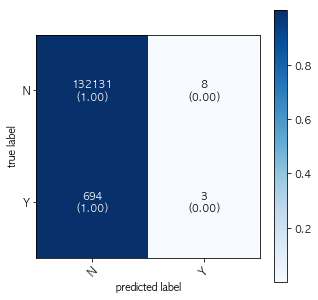

In [91]:
class_names = ['N', 'Y']
fig, ax = plot_confusion_matrix(conf_mat = cm, show_absolute=True, show_normed=True, colorbar=True, class_names = class_names)

plt.rcParams["figure.figsize"] = (5, 5)
plt.show()

In [92]:
1 + 1

2

In [216]:
'''LightGBM'''

lgbc = LGBMClassifier(n_estimators=100, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2, max_bin = 32,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40, class_weight = 'balanced')

'''lgbc = LGBMClassifier(n_estimators=100, learning_rate=0.05, num_leaves=512, colsample_bytree=0.2,
                      application = 'binary', boositing = 'goss',
           reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40, max_depth = 50, class_weight = 'balanced',
                     max_bins = 50, min_sum_hessian_in_leaf = 30, min_data_in_leaf = 100)'''

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)
lgbc.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.2, importance_type='split',
               learning_rate=0.05, max_bin=32, max_depth=-1,
               min_child_samples=20, min_child_weight=40, min_split_gain=0.01,
               n_estimators=100, n_jobs=-1, num_leaves=32, objective=None,
               random_state=None, reg_alpha=3, reg_lambda=1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [205]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

15 selected features


In [217]:
y_pred = lgbc.predict(X_test)
y_pred.shape

(132836,)

In [218]:
# Confusion Matrix의 4가지 결과값 도출
cm = confusion_matrix(y_test, y_pred)

In [219]:
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]

acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp+fp)
sen = tp / (tp+fn)
spec = tn / (fp + tn)

print('정확도 (Accuracy): %f , 정밀도 (Precision): %f , 재현율 (Recall): %f , 특이도 (Specificity): %f' % (acc, prec, sen, spec))

정확도 (Accuracy): 0.778419 , 정밀도 (Precision): 0.016693 , 재현율 (Recall): 0.695652 , 특이도 (Specificity): 0.778865


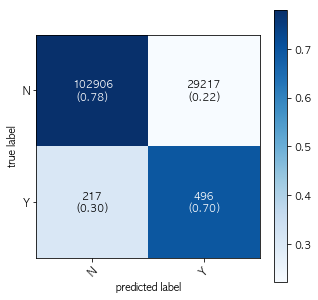

In [220]:
class_names = ['N', 'Y']
fig, ax = plot_confusion_matrix(conf_mat = cm, show_absolute=True, show_normed=True, colorbar=True, class_names = class_names)

plt.rcParams["figure.figsize"] = (5, 5)
plt.show()

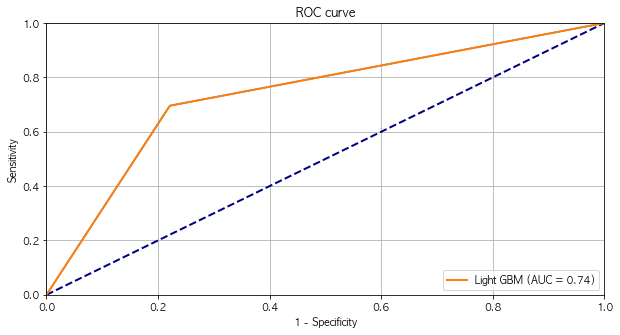

In [221]:
# ROC 커브 및 AUC 도출
FPR, TPR, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10,5))  # figsize in inches
plt.plot(FPR, TPR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 50%
plt.plot(FPR, TPR, lw=2, label='Light GBM (AUC = %0.2f)' % auc(FPR, TPR))
plt.title('ROC curve')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

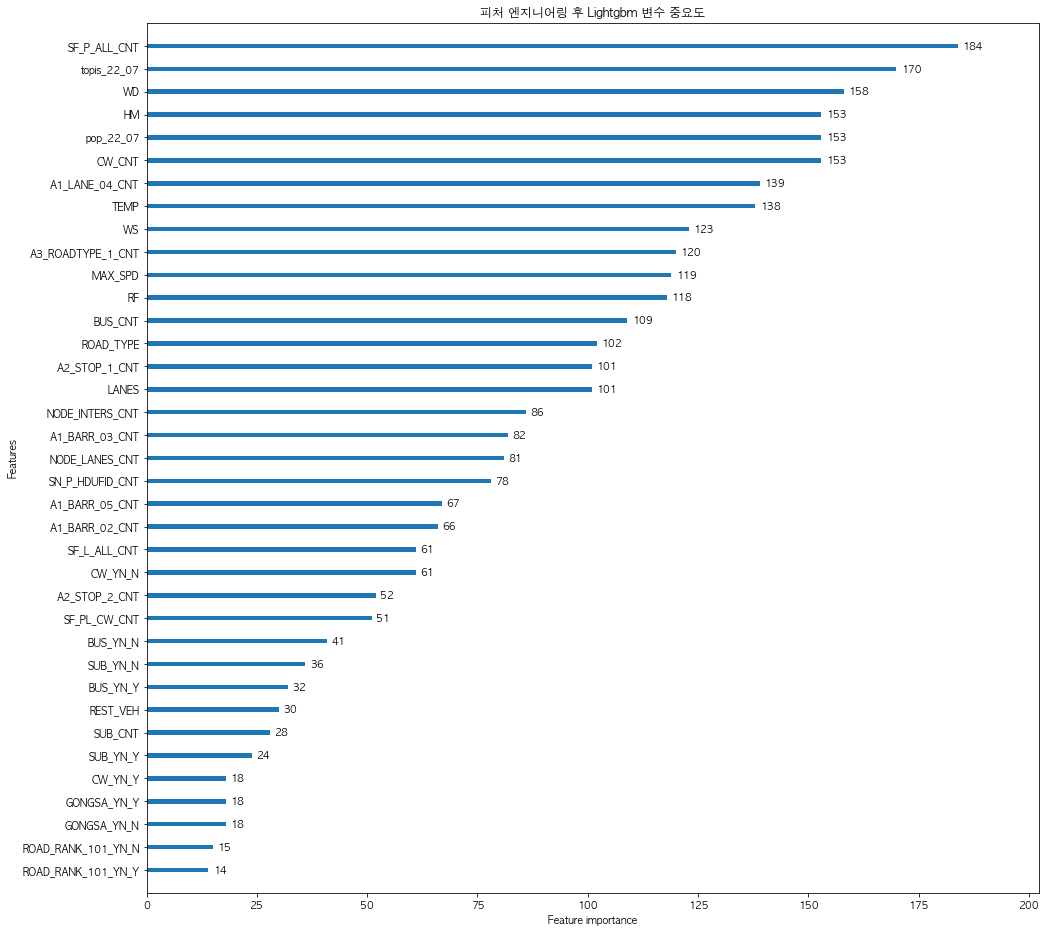

In [223]:
plot_importance(lgbc, grid = False)
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
plt.title('피처 엔지니어링 후 Lightgbm 변수 중요도')
plt.show()

In [603]:
'''ANOVA - F 검정'''
f_selector = SelectKBest(f_classif, k=10)
f_selector.fit(num_X, y)

f_support = f_selector.get_support()
f_feature = num_X.loc[:,f_support].columns.tolist()
print(str(len(f_feature)), 'selected features')

10 selected features


In [604]:
''' 상호정보량 검정'''
mi_selector = SelectKBest(mutual_info_classif, k=45)
mi_selector.fit(X, y)

mi_support = mi_selector.get_support()
mi_feature = X.loc[:,mi_support].columns.tolist()
print(str(len(mi_feature)), 'selected features')

45 selected features


In [605]:
''' 연속형 summary '''
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':num_feature_name, 'Logistics':embeded_lr_support, 
                                    'ANOVA - F':f_support})

In [606]:
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(30)
# test = feature_selection_df.head(30)
# test.to_excel('/Users/wbchoi/Downloads/test.xlsx', index = False)

,Feature,Logistics,ANOVA - F,Total
1,topis_22_07,True,True,2
2,topis_09_19,True,True,2
3,pop_09_19,True,True,2
4,pop_07_09,True,True,2
5,topis_19_22,False,True,1
6,topis_07_09,False,True,1
7,pop_22_07,False,True,1
8,pop_19_22,True,False,1
9,WS,False,True,1
10,TEMP,False,True,1


In [648]:
''' 범주형 summary '''
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':cat_feature_name, 'Chi-2':chi_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(45)
# test = feature_selection_df.head(45)
# test.to_excel('/Users/wbchoi/Downloads/test_2.xlsx', index = False)

,Feature,Chi-2,Total
1,S_P_UTERN_YN,True,1
2,S_P_UTERNX_YN,True,1
3,S_P_UTERNX_CNT,True,1
4,S_P_KIDS_YN,True,1
5,S_P_KIDS_CNT,True,1
6,SUB_YN,True,1
7,SN_P_HDUFID_YN,True,1
8,SF_P_UTERN_YN,True,1
9,SF_P_UTERN_CNT,True,1
10,SF_P_ALL_YN,True,1


In [693]:
''' 연속형 / 범주형 summary '''
pd.set_option('display.max_rows', None)
# put all selection together
# feature_selection_df = pd.DataFrame({'Feature':feature_name, 'MI':mi_support, 'RFE':rfe_support, 'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'LightGBM':embeded_lgb_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(30)
# feature_selection_df.to_excel('/Users/wbchoi/Downloads/test_2.xlsx', index = False)

# 유의 변수 기반 분석


In [718]:
'''연속형 공통, 범주형 공통 변수'''
'''final_data_pca = final_data[['S_P_UTERN_YN', 'S_P_UTERNX_YN', 'S_P_KIDS_YN', 'SUB_YN', 'SN_P_HDUFID_YN', 'SF_P_UTERN_YN', 'SF_L_1_YN', 'ROAD_RANK_101_YN',
                             'NODE_LANES_YN', 'NODE_INTERS_YN', 'HUMP_YN', 'GONGSA_YN', 'CW_YN', 'A3_ROADTYPE_5_YN', 'A3_ROADTYPE_3_YN', 'A3_ROADTYPE_1_YN',
                             'A2_STOP_2_YN', 'A1_LANE_04_YN', 'A1_LANE_02_YN', 'A1_BARR_03_YN', 'A1_BARR_02_YN', 'S_P_UTERN_CNT', 'S_P_UTERNX_CNT', 'S_P_KIDS_CNT',
                             'SUB_CNT', 'SF_P_UTERN_CNT', 'SF_PL_CW_CNT', 'NODE_LANES_CNT', 'BUS_CNT', 'A3_ROADTYPE_3_CNT', 'A2_STOP_1_CNT', 'A1_LANE_04_CNT',
                             'A1_BARR_05_CNT', 'A1_BARR_03_CNT', 'A1_BARR_02_CNT',
                            'topis_22_07시', 'topis_09_19시', 'pop_09_19시', 'pop_07_09시',
                            'SAGO_YN']]'''

'''연속형/범주형 공통변수 (mi, lightgbm, rf, rfe중 3개 이상)'''
'''final_data_pca = final_data[['ROAD_RANK_101_YN', 'CW_YN', 'BUS_YN', 'A3_ROADTYPE_1_YN', 'topis_22_07시', 'topis_19_22시', 'pop_22_07시',
                                'pop_09_19시', 'TEMP', 'SUB_CNT', 'NODE_LANES_CNT', 'CW_CNT', 'A3_ROADTYPE_3_CNT', 'A1_LANE_04_CNT', 
                                'A1_BARR_03_CNT', 'topis_09_19시', 'topis_07_09시', 'pop_07_09시', 'WS', 'WD', 'SN_P_HDUFID_CNT', 'SF_P_ALL_CNT', 
                                 'RF', 'NODE_INTERS_CNT', 'HM', 'BUS_CNT', 'A3_ROADTYPE_1_CNT',
                                'A2_STOP_2_CNT', 'A2_STOP_1_CNT', 'A1_BARR_02_CNT',
                            'SAGO_YN']]'''

'''LightGBM 기반 변수 선택'''
final_data_pca = final_data[['SUB_YN', 'ROAD_TYPE', 'MAX_SPD', 'LANES', 'GONGSA_YN', 'CW_YN', 'ROAD_RANK_101_YN', 'REST_VEH',
                             'BUS_YN', 'SUB_CNT', 'SN_P_HDUFID_CNT', 'SF_P_ALL_CNT', 'SF_PL_CW_CNT', 'SF_L_ALL_CNT', 'NODE_LANES_CNT', 'NODE_INTERS_CNT',
                             'CW_CNT', 'BUS_CNT', 'A3_ROADTYPE_1_CNT', 'A2_STOP_2_CNT', 'A2_STOP_1_CNT', 'A1_LANE_04_CNT', 'A1_BARR_05_CNT', 'A1_BARR_03_CNT',
                             'A1_BARR_02_CNT', 'topis_22_07시', 'topis_19_22시', 'topis_09_19시', 'topis_07_09시', 'pop_22_07시', 'pop_19_22시', 'pop_09_19시',
                             'pop_07_09시', 'WS', 'WD', 'TEMP', 'RF', 'HM',
                             'SAGO_YN']]

In [719]:
final_data_pca.iloc[:, 9:-1].columns

Index(['SUB_CNT', 'SN_P_HDUFID_CNT', 'SF_P_ALL_CNT', 'SF_PL_CW_CNT',
       'SF_L_ALL_CNT', 'NODE_LANES_CNT', 'NODE_INTERS_CNT', 'CW_CNT',
       'BUS_CNT', 'A3_ROADTYPE_1_CNT', 'A2_STOP_2_CNT', 'A2_STOP_1_CNT',
       'A1_LANE_04_CNT', 'A1_BARR_05_CNT', 'A1_BARR_03_CNT', 'A1_BARR_02_CNT',
       'topis_22_07시', 'topis_19_22시', 'topis_09_19시', 'topis_07_09시',
       'pop_22_07시', 'pop_19_22시', 'pop_09_19시', 'pop_07_09시', 'WS', 'WD',
       'TEMP', 'RF', 'HM'],
      dtype='object')

# CNT 변수 표준화/정규화


In [720]:
# 표준화: 평균 0, 분산 1
'''sc = StandardScaler()
final_data_pca.iloc[:, 4:-1] = sc.fit_transform(final_data_pca.iloc[:, 4:-1])
final_data_pca.iloc[:, 4:-1].head()'''

# Min - Max scaling (0 ~ 1 사이 값 변환) : 연속형 및 도로환경변수 (CNT)
sc = MinMaxScaler()
final_data_pca.iloc[:, 9:-1] = sc.fit_transform(final_data_pca.iloc[:, 9:-1])
final_data_pca.iloc[:, 9:-1].head()

# L2 정규화
# final_data_pca.iloc[:, 25:35] = normalize(final_data_pca.iloc[:, 25:35], axis = 1, norm = 'l2')
# final_data_pca.iloc[:, 25:35].head()

/Users/wbchoi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,SUB_CNT,SN_P_HDUFID_CNT,SF_P_ALL_CNT,SF_PL_CW_CNT,SF_L_ALL_CNT,NODE_LANES_CNT,NODE_INTERS_CNT,CW_CNT,BUS_CNT,A3_ROADTYPE_1_CNT,...,topis_07_09시,pop_22_07시,pop_19_22시,pop_09_19시,pop_07_09시,WS,WD,TEMP,RF,HM
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.22222,0.14286,0.00000,...,0.33708,0.02463,0.02114,0.02847,0.01937,0.20402,0.67981,0.36754,0.00000,0.71918
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.22222,0.14286,0.00000,...,0.18555,0.02606,0.03411,0.09203,0.05977,0.33195,0.78484,0.35513,0.00000,0.75277
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.22222,0.14286,0.00000,...,0.19347,0.02776,0.03277,0.09313,0.05846,0.45620,0.85751,0.29574,0.00000,0.73297
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.22222,0.14286,0.00000,...,0.18236,0.02835,0.03447,0.09172,0.05766,0.29601,0.74071,0.28790,0.00000,0.74329
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.22222,0.14286,0.00000,...,0.19567,0.02901,0.03980,0.09067,0.05857,0.27470,0.91056,0.32877,0.00000,0.76303


# 유의 변수 중, 연속형 변수 - 다중공선성 검증

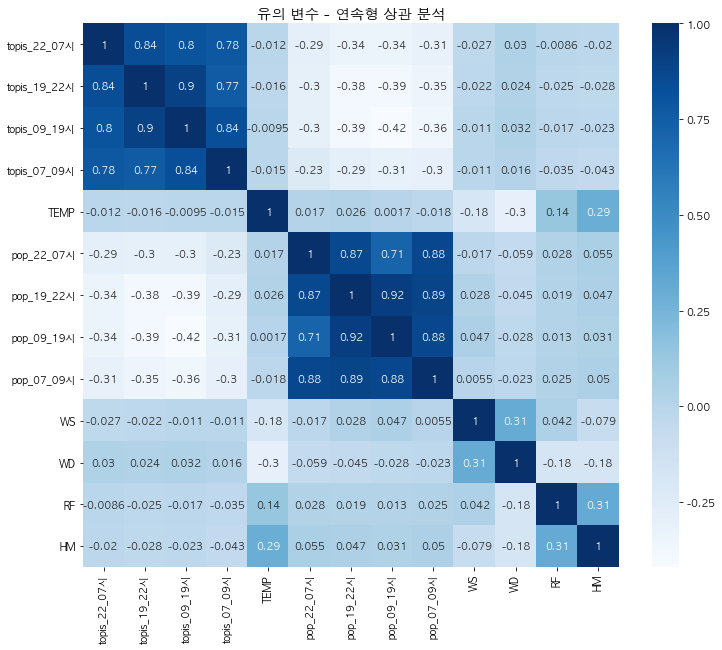

In [615]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = final_data_pca.iloc[:, 7:20].corr(method = 'pearson')
sns.heatmap(cor, annot=True, cmap= 'Blues')

plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.title('유의 변수 - 연속형 상관 분석')
plt.show()

In [721]:
final_data_pca = final_data_pca.drop(['pop_19_22시', 'pop_09_19시', 'pop_07_09시', 'topis_07_09시', 'topis_09_19시', 'topis_19_22시'], axis = 1)

In [617]:
final_data_pca.columns

Index(['ROAD_RANK_101_YN', 'A3_ROADTYPE_1_YN', 'SUB_YN', 'MAX_SPD', 'LANES',
       'ROAD_TYPE', 'BUS_YN', 'topis_22_07시', 'TEMP', 'pop_22_07시', 'WS', 'WD',
       'RF', 'HM', 'NODE_LANES_CNT', 'CW_CNT', 'BUS_CNT', 'A3_ROADTYPE_3_CNT',
       'A1_BARR_03_CNT', 'A1_BARR_02_CNT', 'SUB_CNT', 'SN_P_HDUFID_CNT',
       'SF_P_ALL_CNT', 'A3_ROADTYPE_1_CNT', 'A2_STOP_1_CNT', 'A1_LANE_04_CNT',
       'SF_PL_CW_CNT', 'SF_L_1_CNT', 'NODE_INTERS_CNT', 'A2_STOP_2_CNT',
       'SAGO_YN'],
      dtype='object')

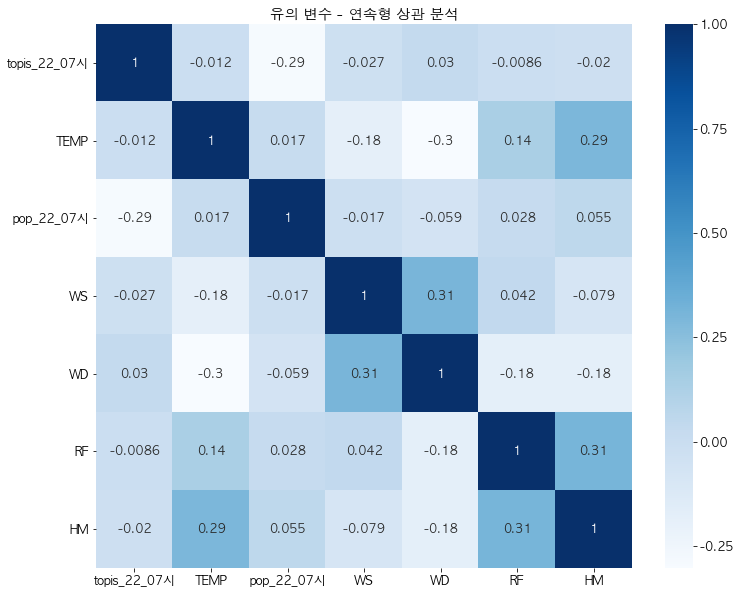

In [618]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = final_data_pca.iloc[:, 7:14].corr(method = 'pearson')
sns.heatmap(cor, annot=True, cmap= 'Blues')

plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.title('유의 변수 - 연속형 상관 분석')
plt.show()

# YN변수 -> dummy 변수 변환

In [722]:
df_dummies = pd.get_dummies(final_data_pca[['SUB_YN', 'ROAD_TYPE', 'MAX_SPD', 'LANES', 'GONGSA_YN', 'CW_YN', 'ROAD_RANK_101_YN', 'REST_VEH',
                             'BUS_YN'
                             ]])

In [723]:
final_data_pca = final_data_pca.drop(['SUB_YN', 'ROAD_TYPE', 'MAX_SPD', 'LANES', 'GONGSA_YN', 'CW_YN', 'ROAD_RANK_101_YN', 'REST_VEH',
                             'BUS_YN'], axis = 1)

In [724]:
df_new = pd.concat([df_dummies, final_data_pca], axis=1)

In [725]:
df_new.shape

(664178, 38)

In [726]:
df_new.head()

,ROAD_TYPE,MAX_SPD,LANES,REST_VEH,SUB_YN_N,SUB_YN_Y,GONGSA_YN_N,GONGSA_YN_Y,CW_YN_N,CW_YN_Y,...,A1_BARR_03_CNT,A1_BARR_02_CNT,topis_22_07시,pop_22_07시,WS,WD,TEMP,RF,HM,SAGO_YN
0,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.27067,0.02463,0.20402,0.67981,0.36754,0.00000,0.71918,N
1,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.28766,0.02606,0.33195,0.78484,0.35513,0.00000,0.75277,N
2,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.28087,0.02776,0.45620,0.85751,0.29574,0.00000,0.73297,N
3,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.27155,0.02835,0.29601,0.74071,0.28790,0.00000,0.74329,N
4,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.28865,0.02901,0.27470,0.91056,0.32877,0.00000,0.76303,N


In [727]:
df_new['SAGO_YN'] = df_new.apply(lambda x: 1 if x['SAGO_YN'] == 'Y' else 0, axis = 1)

In [728]:
# df_new.to_csv('final_data_pca_scaling_dummy_road_rank.csv', index = False)
df_new.to_csv('final_data_pca_minmax_dummy_raod_rank.csv', index = False)

In [729]:
df_new.head()

,ROAD_TYPE,MAX_SPD,LANES,REST_VEH,SUB_YN_N,SUB_YN_Y,GONGSA_YN_N,GONGSA_YN_Y,CW_YN_N,CW_YN_Y,...,A1_BARR_03_CNT,A1_BARR_02_CNT,topis_22_07시,pop_22_07시,WS,WD,TEMP,RF,HM,SAGO_YN
0,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.27067,0.02463,0.20402,0.67981,0.36754,0.00000,0.71918,0
1,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.28766,0.02606,0.33195,0.78484,0.35513,0.00000,0.75277,0
2,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.28087,0.02776,0.45620,0.85751,0.29574,0.00000,0.73297,0
3,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.27155,0.02835,0.29601,0.74071,0.28790,0.00000,0.74329,0
4,0,60.00000,5.00000,0,1,0,1,0,0,1,...,0.00000,0.00000,0.28865,0.02901,0.27470,0.91056,0.32877,0.00000,0.76303,0
